### DP solutions

#### 4.1
**Answer**

$q_{\pi}(11,down) = 1$ and $-15.0$

#### 4.2
**Answer**

+ $v_{\pi}(15)=-20$
+ $v_{\pi}(13)=-20$

#### 4.3
**Answer**

$$
    q_{k+1}(s, a) = \sum_{s', r} p(s', r | s, a)\left[r + \gamma \sum_{a'} \pi(a'|s)q_k(s', a')\right]
$$

#### 4.4
**Answer**

$$
     \text{use if } old-action \neq \pi(s) \text{ and the Q-value of } \pi(s) > \text{that of } old-action
$$

#### 4.5
**Answer**

1. Initialization

    initialize $Q(s, a)$ and $\pi(s)$ arbitrarily for every $s \in S$ and $a \in A(s)$.
2. Policy Evaluation

    loop:

    the update equation is:

    $Q(s,a) \leftarrow \sum_{s',r}p(s',r|s,a)[r+\gamma\sum_{a'}\pi(a'|s')Q(s',a')]$

3. Policy Improvement

    the update is:

    for each $s \in S$:

    $\pi(s) \leftarrow arg\max_{a}Q(s,a)$

#### 4.6
**Answer**

1. no change
2. $V(s) \leftarrow \sum_{a\in A(s)}\pi(a|s)\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')]$
3. $\pi(a|s) = \max(0,\mathbb{1}(a=arg\max_{a}\sum_{s',r}p(s',r|s,a)[r+\gamma V(s')])-\epsilon) + \frac{\epsilon}{|A(S)|}$

#### 4.7

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import exp, factorial
import seaborn as sns
# maximum # of cars in each location
MAX_CARS = 10
# maximum # of cars to move during night
MAX_MOVE_OF_CARS = 5
# expectation for rental requests in first location
RENTAL_REQUEST_FIRST_LOC = 3
# expectation for rental requests in second location
RENTAL_REQUEST_SECOND_LOC = 4
# expectation for # of cars returned in first location
RETURNS_FIRST_LOC = 3
# expectation for # of cars returned in second location
RETURNS_SECOND_LOC = 2
DISCOUNT = 0.9
# credit earned by a car
RENTAL_CREDIT = 10
# cost of moving a car
MOVE_CAR_COST = 2

EXTRA_PLACE_COST = 4

actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)
POISSON_UPPER_BOUND = 11
# Probability for poisson distribution
# @lam: lambda should be less than 10 for this function
poisson_cache = dict()
def poisson(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache.keys():
        poisson_cache[key] = exp(-lam) * pow(lam, n) / factorial(n)
    return poisson_cache[key]

# @state: [# of cars in first location, # of cars in second location]
# @action: positive if moving cars from first location to second location,
#          negative if moving cars from second location to first location
# @stateValue: state value matrix
# @constant_returned_cars:  if set True, model is simplified such that
#   the # of cars returned in daytime becomes constant
#   rather than a random value from poisson distribution, which will reduce calculation time
#   and leave the optimal policy/value state matrix almost the same
def expected_return(state, action, state_value, constant_returned_cars):
    # initailize total return
    returns = 0.0

    # cost for moving cars
    returns -= MOVE_CAR_COST * abs(action)

    returns += (action > 0) * MOVE_CAR_COST
    
    returns -= max(state[1] + action - MAX_CARS, 0) * EXTRA_PLACE_COST
    
    # go through all possible rental requests
    for rental_request_first_loc in range(0, POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(0, POISSON_UPPER_BOUND):
            # moving cars
            num_of_cars_first_loc = int(min(state[0] - action, MAX_CARS))
            num_of_cars_second_loc = int(min(state[1] + action, MAX_CARS))

            # valid rental requests should be less than actual # of cars
            real_rental_first_loc = min(num_of_cars_first_loc, rental_request_first_loc)
            real_rental_second_loc = min(num_of_cars_second_loc, rental_request_second_loc)

            # get credits for renting
            reward = (real_rental_first_loc + real_rental_second_loc) * RENTAL_CREDIT
        
            num_of_cars_first_loc -= real_rental_first_loc
            num_of_cars_second_loc -= real_rental_second_loc

            # probability for current combination of rental requests
            prob = poisson(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                         poisson(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            if constant_returned_cars:
                # get returned cars, those cars can be used for renting tomorrow
                returned_cars_first_loc = RETURNS_FIRST_LOC
                returned_cars_second_loc = RETURNS_SECOND_LOC
                num_of_cars_first_loc = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(0, POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(0, POISSON_UPPER_BOUND):
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        prob_ = poisson(returned_cars_first_loc, RETURNS_FIRST_LOC) * \
                               poisson(returned_cars_second_loc, RETURNS_SECOND_LOC) * prob
                        returns += prob_ * (reward + DISCOUNT * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns

In [12]:
def q_4_7():
    value = np.zeros((MAX_CARS+1, MAX_CARS+1))
    policy = np.zeros(value.shape, dtype=np.int)
    
    iterations = 0
    
    _, axes = plt.subplots(2,3,figsize=(40,20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()
    while True:
        print(iterations)
        fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations])
        fig.set_ylabel('# cars at first location', fontsize=30)
        fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
        fig.set_xlabel('# cars at second location', fontsize=30)
        fig.set_title('policy %d' % (iterations), fontsize=30)
        delta = 0
        while True:
            new_value = value.copy()
            for i in range(MAX_CARS + 1):
                for j in range(MAX_CARS + 1):
                    new_value[i, j] = expected_return([i, j], policy[i, j], new_value,
                                                      True)
            delta = np.abs(new_value-value).sum()
            value = new_value
            print("delta:", delta)
            if delta < 1e-10:
                break
        new_policy = policy.copy()
        policy_changed = False
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                actions_rewards = []
                for action in actions:
                    if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                        actions_rewards.append(expected_return([i,j],action,value,True))
                    else:
                        actions_rewards.append(-float('inf'))
                new_policy[i,j] = actions[np.argmax(actions_rewards)]
        policy_changed = (policy != new_policy).sum()
        print("policy_changed:", policy_changed)
        if not policy_changed or iterations >= 3:
            fig = sns.heatmap(np.flipud(value), cmap="YlGnBu", ax=axes[-1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('optimal value', fontsize=30)
            
            # policy
            fig = sns.heatmap(np.flipud(policy), cmap="YlGnBu", ax=axes[iterations+1])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(MAX_CARS + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy %d' % (iterations+1), fontsize=30)
            
            
            break
        iterations += 1
    plt.savefig("./img/4_7.png")

**Answer**

<IPython.core.display.Javascript object>


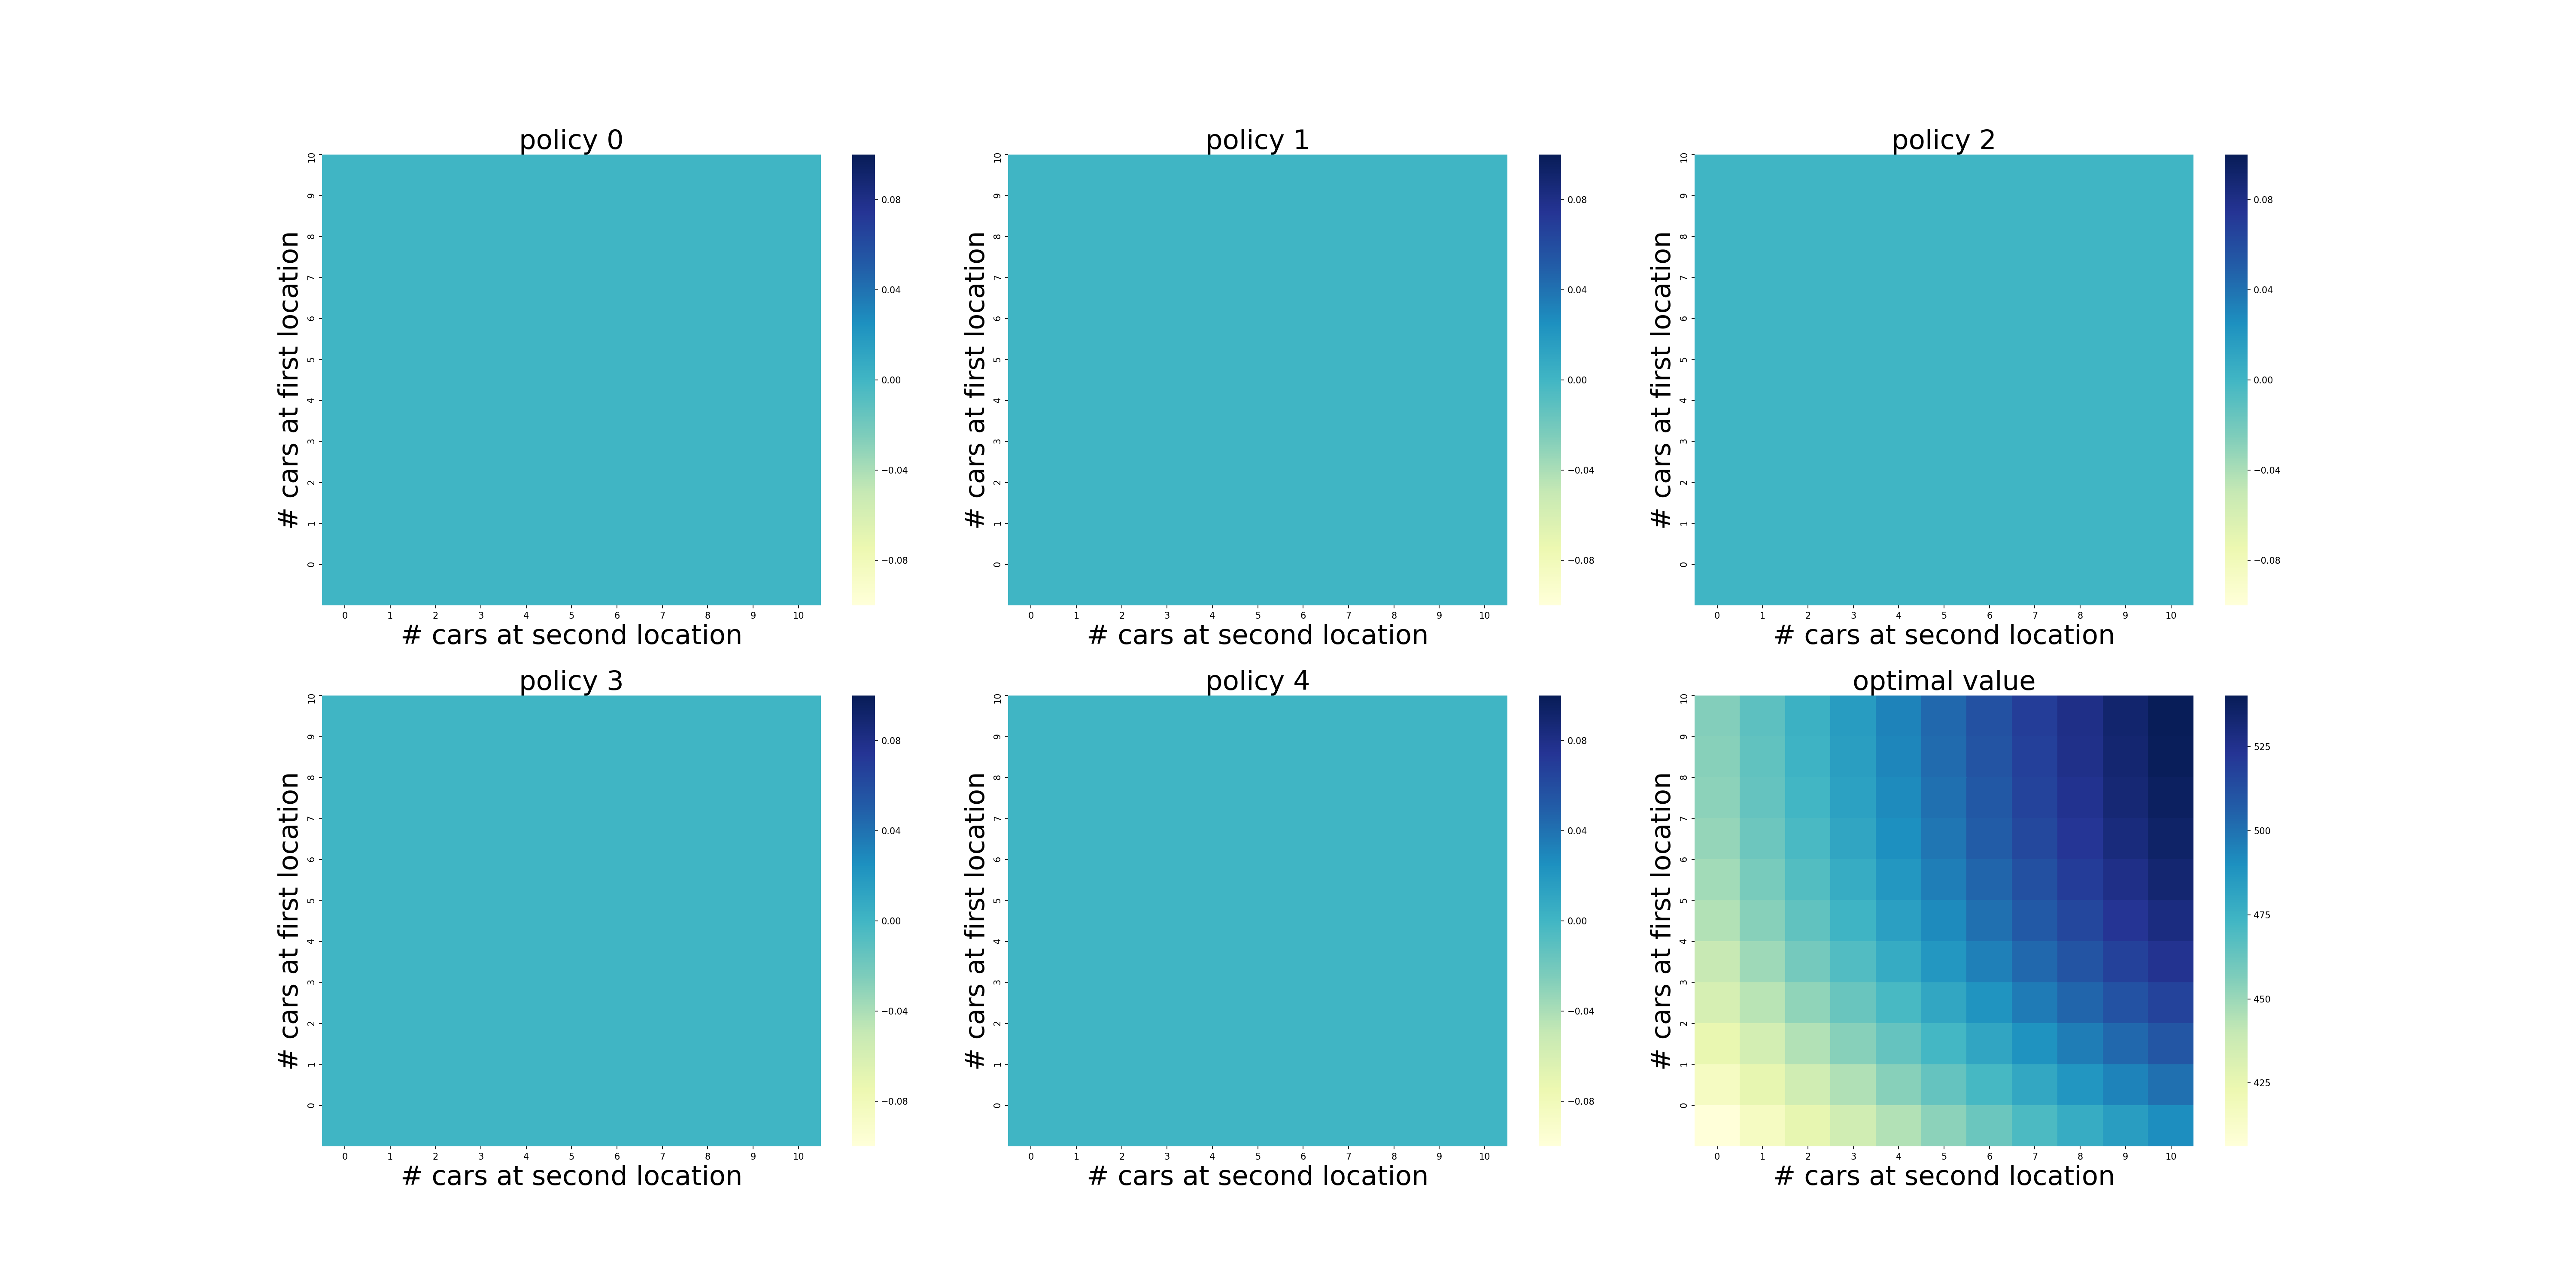

0
delta: 9529.606671661502
delta: 8024.010091631562
delta: 6283.614642053212
delta: 5113.226733767827
delta: 4291.926258695471
delta: 3657.229426767363
delta: 3133.5252787803174
delta: 2688.2670121865685
delta: 2305.5766356374443
delta: 1975.7947433312145
delta: 1691.741111170458
delta: 1447.4205042482984
delta: 1237.5939605802484
delta: 1057.6346591974336
delta: 903.4646068175791
delta: 771.5083850630579
delta: 658.6478872774259
delta: 562.1761883853521
delta: 479.751963729502
delta: 409.35602275086154
delta: 349.2510036269969
delta: 297.9447601450647
delta: 254.1575985453207
delta: 216.79328269127245
delta: 184.91358604889865
delta: 157.71609656069597
delta: 134.51495165904652
delta: 114.7241787982594
delta: 97.84333089773406
delta: 83.44512872295047
delta: 71.16484884130733
delta: 60.69122347736737
delta: 51.75864561957712
delta: 44.1404981121907
delta: 37.6434487066706
delta: 32.10257395633204
delta: 27.377193414328246
delta: 23.34731194568792
delta: 19.91058225631747
delta: 16.979

In [13]:
q_4_7()

#### 4.8
**Answer**

I think this unexpected way can maximize the probability of winning this game, since the probability of winning when the capital is 40 is 0.4, which is quite high.

#### 4.9

In [52]:
# %matplotlib notebook
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# goal
GOAL = 100

# all states, including state 0 and state 100
STATES = np.arange(GOAL + 1)

# probability of head
HEAD_PROBS = [0.25,0.55]
THETAS = np.arange(-12,-8)

def q_4_9():
    # state value
    
    state_value = np.zeros(GOAL + 1)
    state_value[0] = 0
    state_value[GOAL] = 1.0
    plt.figure(figsize=(20, 40))
    for i,HEAD_PROB in enumerate(HEAD_PROBS):
        plt.subplot(1,2,i+1)
        plt.title("HEAD_PROB is %f" %HEAD_PROB)
        for THETA in THETAS:
            # value iteration
            while True:
                delta = 0.0
                for state in STATES[1:GOAL]:
                    # get possilbe actions for current state
                    actions = np.arange(min(state, GOAL - state) + 1)
                    action_returns = []
                    for action in actions:
                        action_returns.append(
                            HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])
                    new_value = np.max(action_returns)
                    delta += np.abs(state_value[state] - new_value)
                    # update state value
                    state_value[state] = new_value
                if delta < float("1e%d"%THETA):
                    break

            # compute the optimal policy
            policy = np.zeros(GOAL + 1)
            for state in STATES[1:GOAL]:
                actions = np.arange(min(state, GOAL - state) + 1)
                action_returns = []
                for action in actions:
                    action_returns.append(
                        HEAD_PROB * state_value[state + action] + (1 - HEAD_PROB) * state_value[state - action])
                action_returns[0] = 0
                policy[state] = actions[np.argmax(np.round(action_returns, 5))]

            
            
            plt.subplot(2, 2, (i+1))
            plt.plot(state_value,label=str(THETA))
            plt.xlabel('Capital')
            plt.ylabel('Value estimates')

            plt.subplot(2, 2, (i+1)+2)
            plt.scatter(STATES, policy,label=str(THETA))
            plt.xlabel('Capital')
            plt.ylabel('Final policy (stake)')
        plt.legend()
    plt.savefig('./img/4_9.png')


**Answer**

<IPython.core.display.Javascript object>


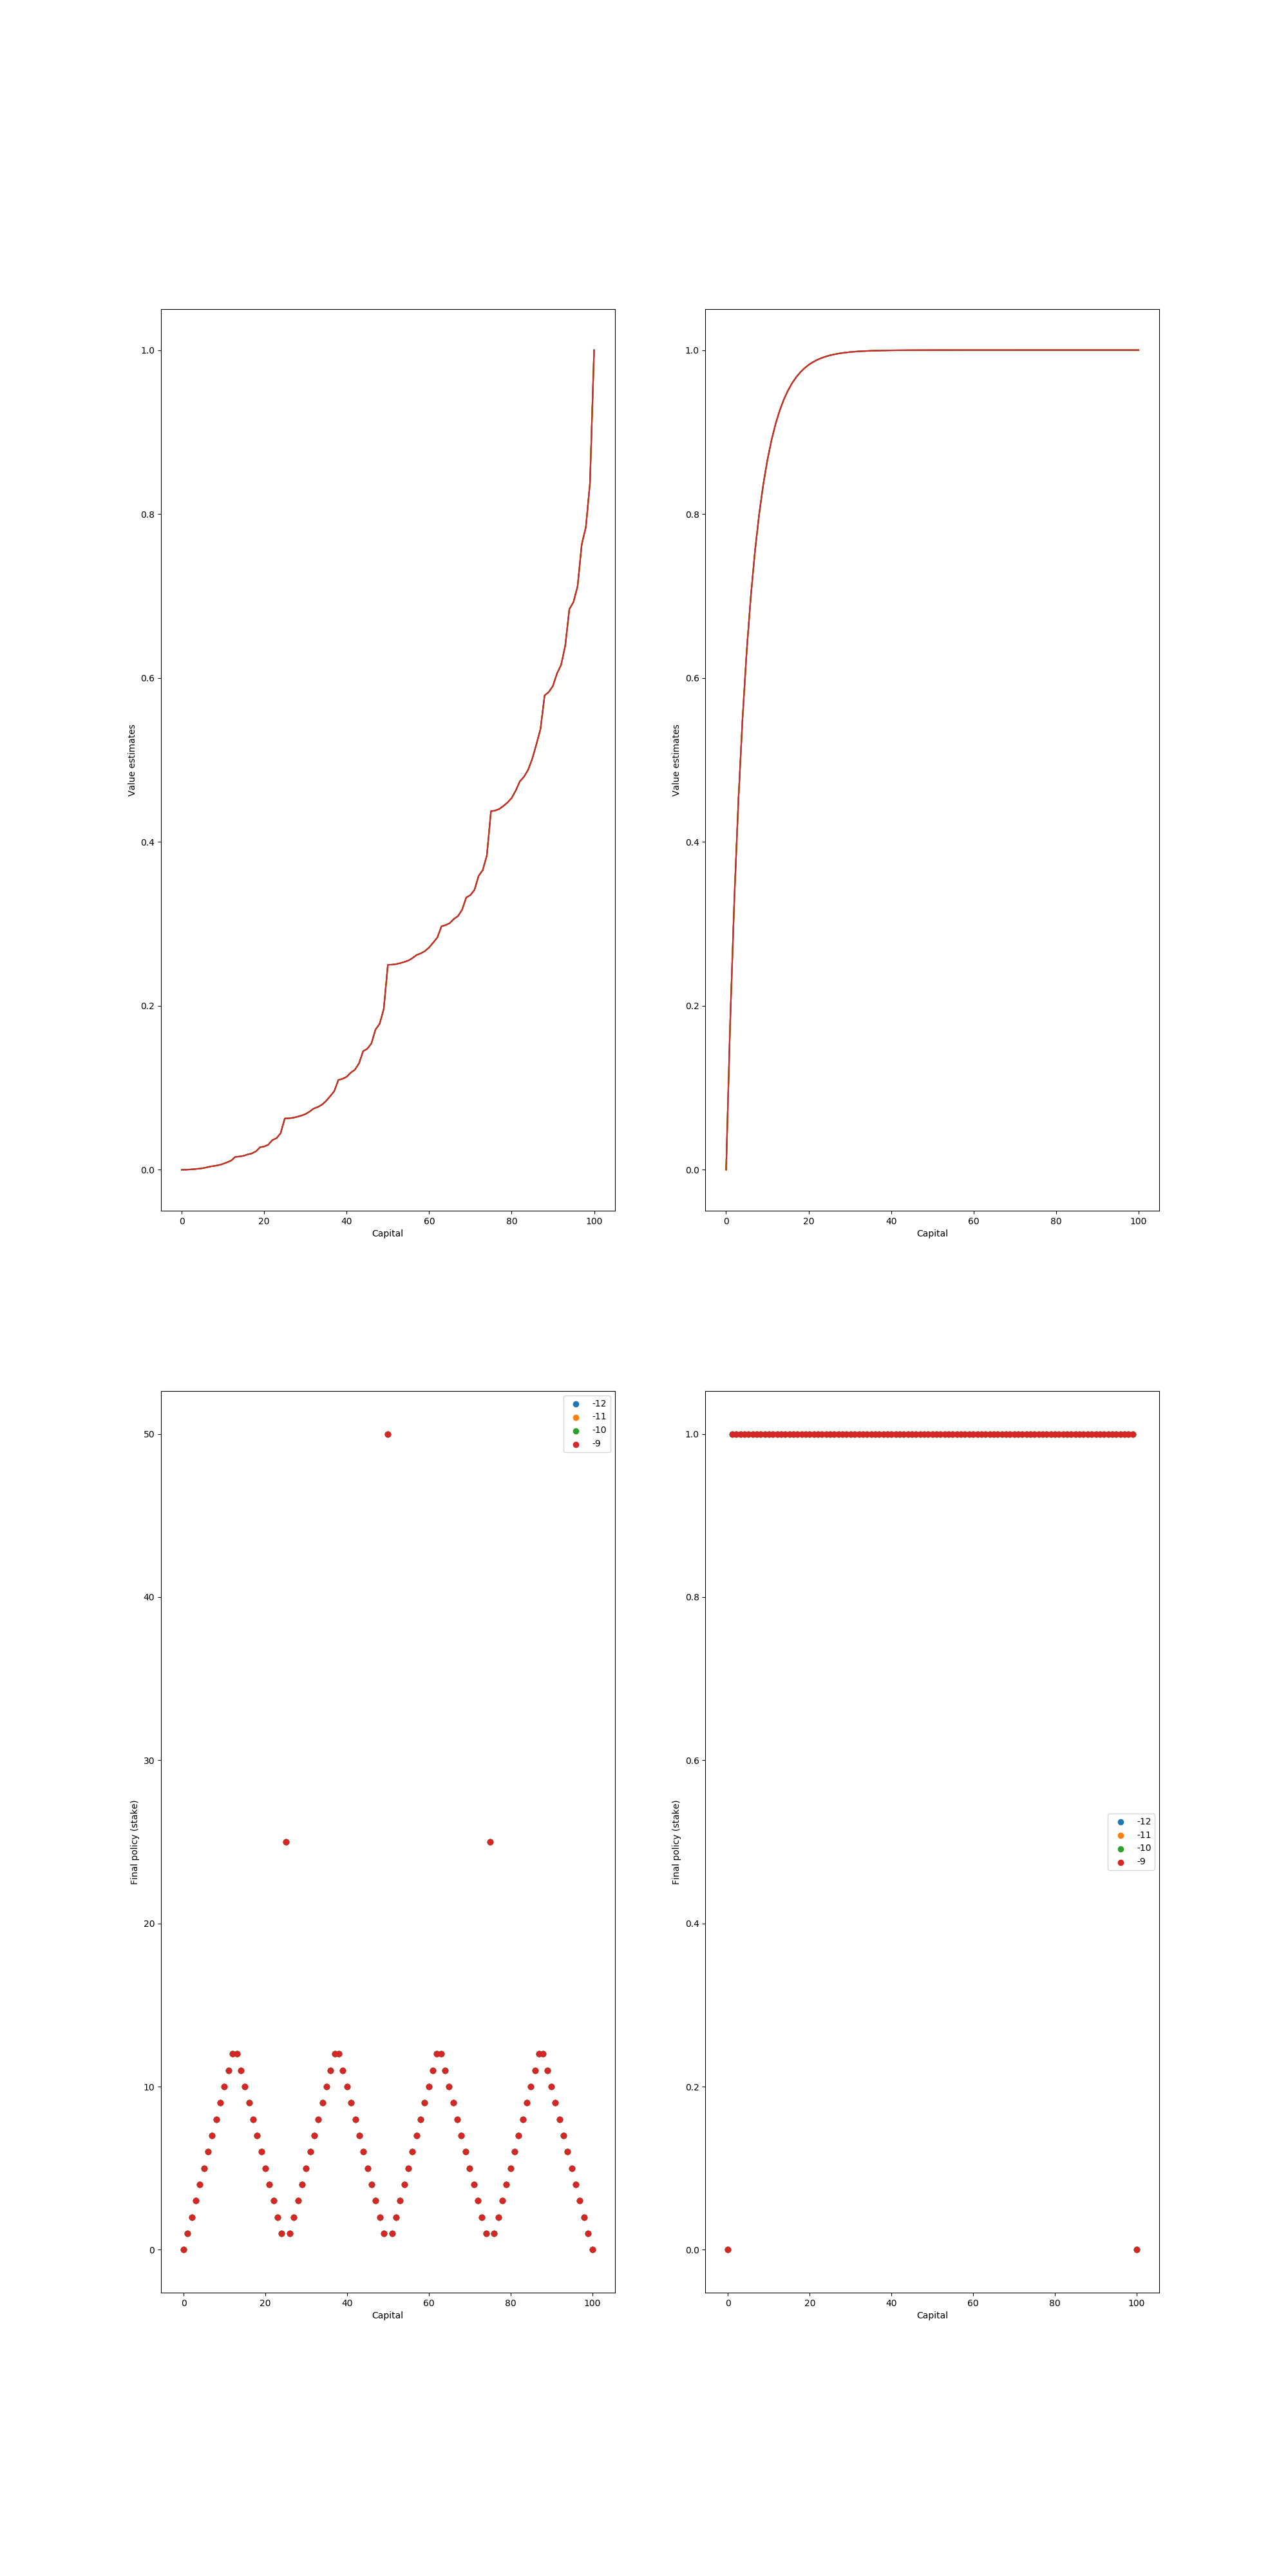

In [53]:
q_4_9()

#### 4.10
**Answer**

$$
    q_{k+1} = \max_{a'}\sum_{s',r}p(s',r|s,a)[r+\gamma q_{k}(s',a')]
$$